In [1]:
import torch

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader, Dataset
from torchtext.data.functional import to_map_style_dataset
from torchtext.datasets import AG_NEWS
from torch.utils.data.dataset import random_split

from bert import EncodedDataset, Classifier_model

/usr/venv/545bert/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def evaluate_topk(model, dataloader, topk=1):
    model.eval()
    total_acc, total_count = 0, 0
    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            label = data['targets'] - torch.ones(data['targets'].shape, dtype=torch.long)
            predicted_label = F.softmax(model(data), dim=1)
            top_preds, top_idx = predicted_label.topk(k=topk, dim=1)
            for i, k in enumerate(top_idx):
                total_acc += int(label[i] in k)
            total_count += label.size(0)
    return total_acc/total_count

In [3]:
device = torch.device("cpu")

batch_size = 16
num_epochs = 64
max_len = 64
vsplit = 0.05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_iter = AG_NEWS(split='train')
trainset = to_map_style_dataset(train_iter)
n_train = int(len(trainset) * vsplit)
n_val = len(trainset) - n_train
valset, trainset = random_split(trainset, [n_train, n_val])

valset = EncodedDataset(valset, tokenizer, max_len, device)
trainset = EncodedDataset(trainset, tokenizer, max_len, device)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=True)

test_iter = AG_NEWS(split='test')
testset = to_map_style_dataset(test_iter)
testset = EncodedDataset(testset[:100], tokenizer, max_len, device)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

print(f"Datasets loaded - train: {len(trainset)}, val: {len(valset)}, test: {len(testset)}")


/usr/venv/545bert/lib/python3.8/site-packages/torch/utils/data/datapipes/utils/common.py:24: UserWarning: Lambda function is not supported for pickle, please use regular python function or functools.partial instead.
  warnings.warn(


Datasets loaded - train: 114000, val: 6000, test: 100


In [4]:
model = torch.load('saved_bert', map_location=torch.device('cpu'))
for name, param in model.named_parameters():
    param.requires_grad = True

In [5]:
evaluate_topk(model, testloader, topk=1)

0.81

In [6]:
idx2label = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tec'}

In [7]:
def _register_embedding_list_hook(model, embeddings_list):
    def forward_hook(module, inputs, output):
        embeddings_list.append(output.squeeze(0).clone().cpu().detach().numpy())
    embedding_layer = model.bert.embeddings.word_embeddings
    handle = embedding_layer.register_forward_hook(forward_hook)
    return handle

def _register_embedding_gradient_hooks(model, embeddings_gradients):
    def hook_layers(module, grad_in, grad_out):
        embeddings_gradients.append(grad_out[0])
    embedding_layer = model.bert.embeddings.word_embeddings
    hook = embedding_layer.register_full_backward_hook(hook_layers)
    return hook


In [8]:
def compute_bert_saliency_map(X, label, model, loss):
    torch.enable_grad()

    embeddings_list = []
    handle = _register_embedding_list_hook(model, embeddings_list)
    embeddings_gradients = []
    hook = _register_embedding_gradient_hooks(model, embeddings_gradients)

    model.zero_grad()
    A = model(X)
    #pred_label_ids = np.argmax(A.logits[0].detach().numpy())
    A[0,label].backward()
    handle.remove()
    hook.remove()

    saliency_grad = embeddings_gradients[0].detach().cpu().numpy()  
    saliency_grad = np.sum(saliency_grad[0] * embeddings_list[0], axis=1)
    norm = np.linalg.norm(saliency_grad, ord=1)
    # saliency_grad = [e / norm for e in saliency_grad] 
    saliency = np.array([e / norm for e in saliency_grad])
    return saliency


In [9]:
def show_text_saliency_maps(X, y, tokenizer, correct_label, label_dict, model):

    prediction = model(X)
    predicted_class = prediction.argmax()
    print(f'The predicted class is: {label_dict[predicted_class.item()]}, the correct class is: {correct_label}')
    y_tensor = torch.LongTensor(y)
    saliencies = np.zeros(shape = (X['ids'].shape[1], *y.size()))

    loss = nn.CrossEntropyLoss()
    
    for i, label in enumerate(y):
        saliencies[:, i] = compute_bert_saliency_map(X, label, model, loss)
        
    detoked = np.array(tokenizer.decode(X['ids'].flatten()).split())

    N = y.size()[0]
    pad_idx = np.min(np.where(detoked == '[SEP]')[0])
    x_ticks = np.arange(pad_idx+1)
    fig, axes = plt.subplots(N, 1, sharex=False, sharey=False, figsize=(8,60))
    for i, label in enumerate(y):
        axes[i].plot(saliencies[:pad_idx+1, i], x_ticks, '-o')
        # axes[i].set_xticklabels(np.linspace(start=0, stop=saliencies[:, i].max(), num=10))
        axes[i].set_yticks(ticks=x_ticks, labels=detoked[:pad_idx+1])
        axes[i].set_title(f'class \'{label_dict[label.item()]}\' prediction')
        axes[i].invert_yaxis()
    plt.show()

In [10]:
n = np.random.randint(low=0, high=len(testset))
test_point = testset[n]

The predicted class is: World, the correct class is: World


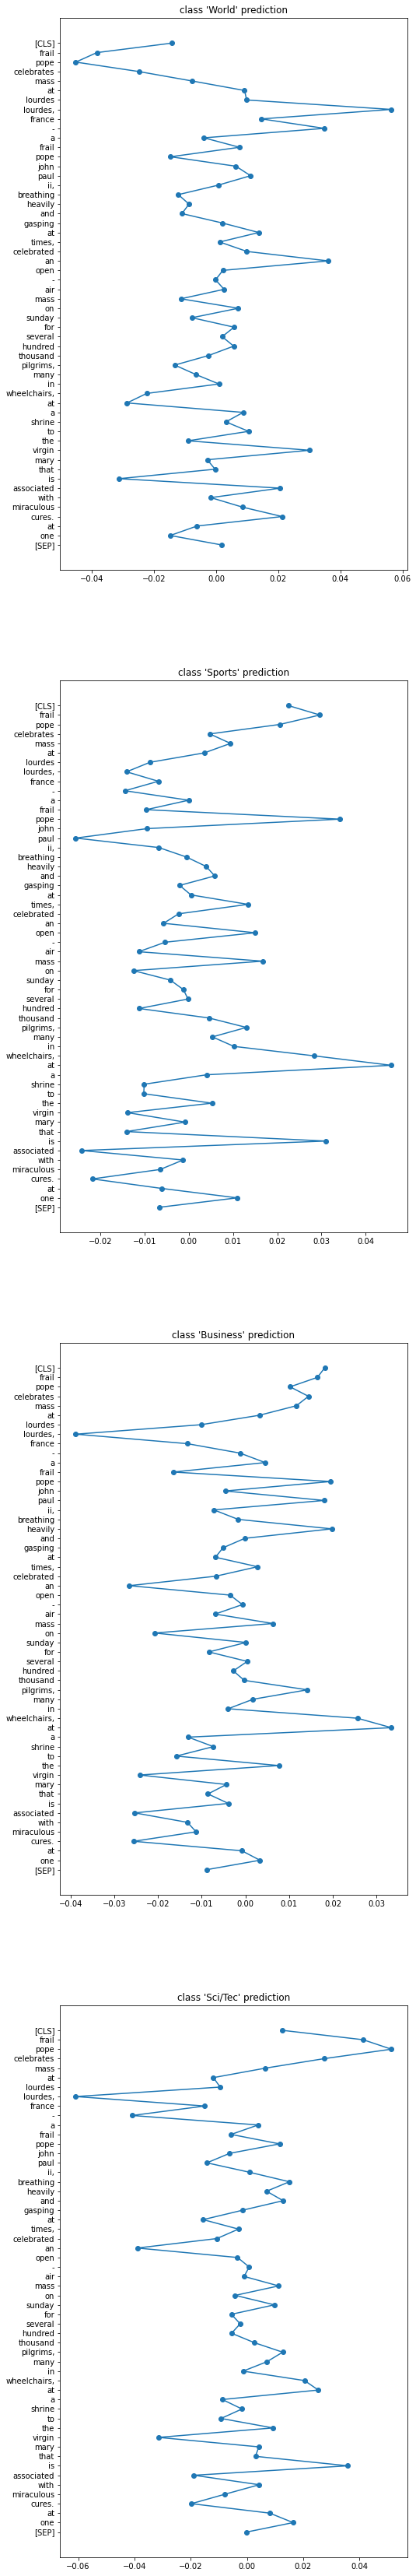

In [11]:
idx = test_point['targets'].item()-1
label = idx2label[idx]
for key in test_point:
    test_point[key] = torch.reshape(test_point[key], shape=(1,-1))

show_text_saliency_maps(test_point, torch.tensor([0, 1, 2, 3]), tokenizer, label, idx2label, model)